In [1]:
import pandas as pd
import numpy as np
import os
from matplotlib import pyplot as plt
import seaborn as sns
from Models import probitModel, logisticModel
from util import *
from sklearn.preprocessing import *
from sklearn.impute import *

import json
import joblib

In [2]:
SEED = 1

data_folder = 'data'
df = pd.read_csv(os.path.join(data_folder,'mimiciv_traindata.csv'))
df.head()

,Fraction inspired oxygen_mean,Fraction inspired oxygen_min,Fraction inspired oxygen_max,Glucose_mean,Glucose_min,Glucose_max,Heart Rate_mean,Heart Rate_min,Heart Rate_max,Mean blood pressure_mean,...,Temperature_mean,Temperature_min,Temperature_max,Weight_mean,Weight_min,Weight_max,pH_mean,pH_min,pH_max,mortality
0,0.484615,0.4,0.6,155.181818,52.0,280.0,52.367347,35.0,93.0,87.096154,...,36.356349,35.200000,37.100000,81.419764,81.419764,81.419764,7.328750,7.19,7.40,1.0
1,0.600000,0.5,1.0,127.954545,85.0,177.0,72.660377,58.0,105.0,72.315789,...,36.786325,36.388889,37.055556,93.103510,91.807021,95.000000,7.377143,7.34,7.42,0.0
2,0.481250,0.4,0.8,145.625000,116.0,180.0,107.260000,96.0,118.0,86.462963,...,37.316239,36.611111,37.944444,67.500000,67.500000,67.500000,7.372000,7.29,7.45,0.0
3,0.400000,0.4,0.4,100.142857,77.0,154.0,57.250000,47.0,65.0,69.762712,...,NaN,NaN,NaN,80.403091,76.838485,86.000000,7.161250,6.00,7.36,1.0
4,0.566667,0.4,1.0,138.000000,116.0,155.0,84.015625,64.0,114.0,70.662162,...,36.148990,34.722222,37.666667,NaN,NaN,NaN,7.374444,7.27,7.42,1.0


In [3]:
x = compute_features(df.drop('mortality',axis=1))
y = df.mortality.values



In [4]:
base_pipeline = [
    ('scaler', QuantileTransformer(output_distribution='normal', ignore_implicit_zeros=False)),
]

with open('probit.json','r') as f:
    probit_param = json.load(f)
with open('logistic.json','r') as f:
    logistic_param = json.load(f)

print(probit_param)
print(logistic_param)
    

{'l1': 0.01408463968126994, 'l2': 0.02342531550932314, 'n_neighbors': 6.122179621653704}
{'l1': 0.2168472356533766, 'l2': 0.5551926359441683, 'n_neighbors': 3.0167325987967226}


# Probit Model

In [5]:
probit_pipeline = base_pipeline + [
        ('iso_forest', FeatureTransformer(fnames=x.columns, n_neighbors=int(probit_param['n_neighbors']))),
        ('imputer', KNNImputer(missing_values=np.nan, n_neighbors=int(probit_param['n_neighbors']))),
]
probit_pipeline = Pipeline(probit_pipeline)
probit_x = probit_pipeline.fit_transform(x)
probit = probitModel(l1=probit_param['l1'], l2=probit_param['l2'], w=0.75)

res_dict = probit.fit(probit_x, y, verbose=True, wald=True)
result = res_dict['result']
loss_values = res_dict['loss']

Current loss: 0.8650147911044017
Current loss: 0.664131268591634
Current loss: 0.5651551760912967
Current loss: 0.5098817316941787
Current loss: 0.5037841237632393
Current loss: 0.5021706080927653
Current loss: 0.5041625229916321
Current loss: 0.5034496737510967
Current loss: 0.5054315624713007
Current loss: 0.5046459947631536
Current loss: 0.5072062251588415
Optimization result: Optimization terminated successfully
Wald test summary:
+----+---------+--------------+-----------+---------+---------+
|    |   index |         coef |   std err |       z |   P>|z| |
|----+---------+--------------+-----------+---------+---------|
|  0 |      25 | -0.0591783   |    0.0518 | -1.1414 |  0.2537 |
|  1 |      21 |  0.0949772   |    0.086  |  1.1045 |  0.2694 |
|  2 |      19 | -0.0320317   |    0.0328 | -0.9757 |  0.3292 |
|  3 |      24 | -0.0634395   |    0.0787 | -0.8064 |  0.42   |
|  4 |      66 | -0.0365839   |    0.0591 | -0.6191 |  0.5358 |
|  5 |       8 |  0.0601579   |    0.1155 |  0.52

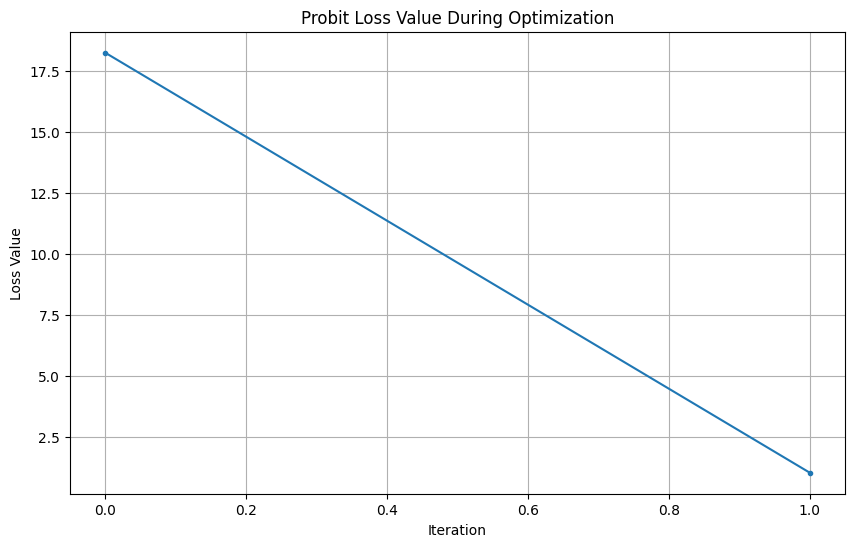

In [13]:
plt.figure(figsize=(10, 6))
plt.plot(loss_values, marker='.', linestyle='-')
plt.title('Probit Loss Value During Optimization')
plt.xlabel('Iteration')
plt.ylabel('Loss Value')
plt.grid()
plt.show()

## Wald test result and model interpretation

In [14]:
# iso_forest in pipeline will add a feature 'is_outlier', and last parameter in the model is the bias term
fnames = x.columns.to_list()+['is_outlier']+['bias']
# map the indices back to feature names
index_to_feature = dict(zip(range(len(fnames)),fnames))
wald_res = res_dict['wald_result']
wald_res['index'] = wald_res['index'].replace(index_to_feature, inplace=False)
wald_res.rename(columns={'index':'feature'}, inplace=True)
# filter out the significant features with 5% significance level
wald_res.query('`P>|z|` < 0.05')


KeyError: 'index'

### Interpretation
Positive coef -> higher feature value, higher mortality risk

Negative coef -> higher feature value, lower mortality risk
- Higher Respiratory rate_mean increases mortality risk
- Higher Heart Rate_max increases mortality risk
- Higher Oxygen saturation_min decrease mortality risk (or lower increase risk)
- Higher Temperature_min decrease mortality risk (or lower increase risk)
- Higher pH_min decrease mortality risk (or lower increase risk)
- Higher Respiratory rate_min decrease mortality risk (or lower increase risk)

## Saving the model

In [8]:
joblib.dump(probit_pipeline, 'probit_pipeline.pkl')
joblib.dump(probit, 'probit.pkl')

['probit.pkl']

# Logistic Model

In [9]:
logistic_pipeline = base_pipeline + [ #
        ('iso_forest', FeatureTransformer(fnames=x.columns, n_neighbors=int(logistic_param['n_neighbors']))),
        ('imputer', KNNImputer(missing_values=np.nan, n_neighbors=int(logistic_param['n_neighbors']))),
]
logistic_pipeline = Pipeline(logistic_pipeline)
logistic_x = logistic_pipeline.fit_transform(x)
logistic = logisticModel(l1=logistic_param['l1'], l2=logistic_param['l2'], w=0.75)

res_dict = logistic.fit(logistic_x, y, verbose=True, wald=True, tol=1e-4)
result = res_dict['result']
loss_values = res_dict['loss']


Current loss: 18.24740089266604
Current loss: 1.0448382259504236
Optimization result: Optimization terminated successfully
Wald test summary:
+----+---------+--------------+-----------+---------+---------+
|    |   index |         coef |   std err |       z |   P>|z| |
|----+---------+--------------+-----------+---------+---------|
|  0 |      31 | -4.39432e-05 |    0.0293 | -0.0015 |  0.9988 |
|  1 |      19 | -4.33474e-05 |    0.0514 | -0.0008 |  0.9993 |
|  2 |      30 | -3.42215e-05 |    0.0774 | -0.0004 |  0.9996 |
|  3 |      32 | -2.99382e-05 |    0.0631 | -0.0005 |  0.9996 |
|  4 |      25 | -4.12343e-05 |    0.0805 | -0.0005 |  0.9996 |
|  5 |      58 | -3.88605e-05 |    0.0858 | -0.0005 |  0.9996 |
|  6 |      13 | -3.876e-05   |    0.0962 | -0.0004 |  0.9997 |
|  7 |      44 | -2.88537e-05 |    0.0709 | -0.0004 |  0.9997 |
|  8 |      10 | -4.01988e-05 |    0.1054 | -0.0004 |  0.9997 |
|  9 |      16 | -4.38552e-05 |    0.1128 | -0.0004 |  0.9997 |
| 10 |      22 | -3.41017e

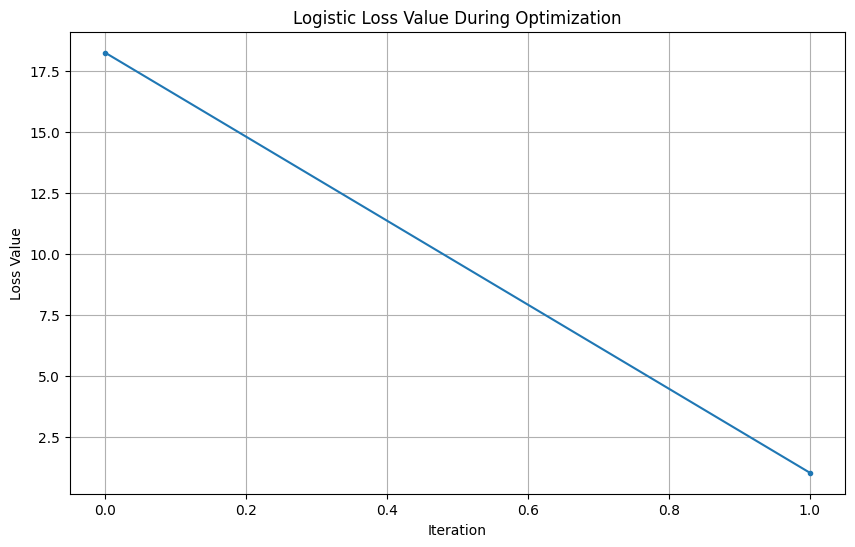

In [10]:
plt.figure(figsize=(10, 6))
plt.plot(loss_values, marker='.', linestyle='-')
plt.title('Logistic Loss Value During Optimization')
plt.xlabel('Iteration')
plt.ylabel('Loss Value')
plt.grid()
plt.show()

## Wald test result and model interpretation

In [11]:
# iso_forest in pipeline will add a feature 'is_outlier', and last parameter in the model is the bias term
fnames = x.columns.to_list()+['is_outlier']+['bias']
# map the indices back to feature names
index_to_feature = dict(zip(range(len(fnames)),fnames))
wald_res = res_dict['wald_result']
wald_res['index'] = wald_res['index'].replace(index_to_feature, inplace=False)
wald_res.rename(columns={'index':'feature'}, inplace=True)
# filter out the significant features with 5% significance level
wald_res.query('`P>|z|` < 0.05')


,feature,coef,std err,z,P>|z|


### Interpretation
Positive coef -> higher feature value, higher mortality risk

Negative coef -> higher feature value, lower mortality risk
- Higher Respiratory rate_mean increases mortality risk
- Higher Heart Rate_max increases mortality risk
- Higher Oxygen saturation_min decrease mortality risk (or lower increase risk)
- Higher Temperature_min decrease mortality risk (or lower increase risk)
- Higher pH_min decrease mortality risk (or lower increase risk)
- Higher Respiratory rate_min decrease mortality risk (or lower increase risk)

(Consistent with the probit model result)

## Saving the model

In [12]:
joblib.dump(logistic_pipeline, 'logistic_pipeline.pkl')
joblib.dump(logistic, 'logistic.pkl')

['logistic.pkl']